In [287]:
import os
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs

import mapclassify as mc
import matplotlib.colors as colors
import matplotlib as mpl

from wordcloud import WordCloud, STOPWORDS

plt.style.use('default')
plt.style.use('dark_background')

In [288]:
posts = pd.concat([
    pd.read_csv('posts_1.csv'),
    pd.read_csv('posts_2.csv'),
    pd.read_csv('posts_3.csv'),
    pd.read_csv('posts_4.csv'),
    pd.read_csv('posts_5.csv'),
    pd.read_csv('posts_6.csv'),
    pd.read_csv('posts_7.csv'),
    pd.read_csv('posts_8.csv'),
    pd.read_csv('posts_9.csv')
], sort=False)

posts.shape

(149152, 52)

In [289]:
posts.drop_duplicates(
    subset=['data.hashtag.edge_hashtag_to_media.edges.node.id'],
    inplace=True,
    keep='last',
)

posts.shape

(62654, 52)

In [290]:
posts

input.hashtag                                       input.max_id  \
0             vote                                                NaN   
1             vote                                                NaN   
2             vote                                                NaN   
3             vote                                                NaN   
4             vote                                                NaN   
...            ...                                                ...   
6737   electionday  QVFCd1ZpWlVsQkFWSXFGTURXOXpmUHJzRy1TdzR6LWo5MH...   
6738   electionday  QVFCd1ZpWlVsQkFWSXFGTURXOXpmUHJzRy1TdzR6LWo5MH...   
6739   electionday  QVFCd1ZpWlVsQkFWSXFGTURXOXpmUHJzRy1TdzR6LWo5MH...   
6740   electionday  QVFCd1ZpWlVsQkFWSXFGTURXOXpmUHJzRy1TdzR6LWo5MH...   
6741   electionday  QVFCd1ZpWlVsQkFWSXFGTURXOXpmUHJzRy1TdzR6LWo5MH...   

      data.hashtag.edge_hashtag_to_media.edges.node.comments_disabled  \
0                                                 False                 
1                                                 False                 
2                                                 False                 
3                                                 False                 
4                                                 False                 
...                                                 ...                 
6737                                              False                 
6738                                              False                 
6739                                              False                 
6740                                              False                 
6741                                              False                 

     data.hashtag.edge_hashtag_to_media.edges.node.__typename  \
0                                            GraphImage         
1                                            GraphImage         
2                                            GraphImage         
3                                            GraphImage         
4                                            GraphVideo         
...                                                 ...         
6737                                         GraphImage         
6738                                         GraphImage         
6739                                         GraphImage         
6740                                         GraphImage         
6741                                         GraphImage         

      data.hashtag.edge_hashtag_to_media.edges.node.id  \
0                                  2170754896654801983   
1                                  2170754885446990462   
2                                  2170754887460939567   
3                                  2170754869458491422   
4                                  2170754171601494709   
...                                                ...   
6737                               2160935156672948658   
6738                               2160919769474448053   
6739                               2159811836881662164   
6740                               2159794944391004447   
6741                               2158211168514869761   

     data.hashtag.edge_hashtag_to_media.edges.node.edge_media_to_caption.edges[0].node.text  \
0     There’s no such thing as an “off-year” electio...                                       
1                              Every vote counts! #vote                                       
2                                       #JustDoIt #vote                                       
3     Bring in your “ I Voted Today” sticker and get...                                       
4     • @instamomofastar And now back by popular dem...                                       
...                                                 ...                                       
6737  Good morning Botswana\nIts #ElectionDay today....                                       
6738  #electi

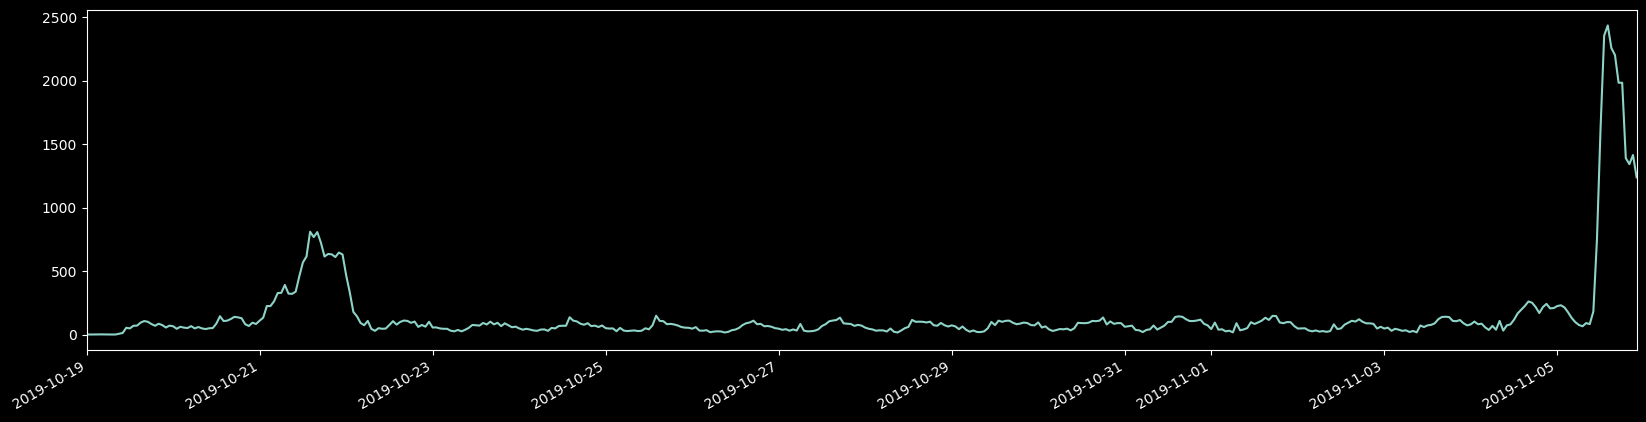

In [291]:
posts['posted_datetime'] = pd.to_datetime(
    posts['data.hashtag.edge_hashtag_to_media.edges.node.taken_at_timestamp'],
    unit='s',
)

posts = posts.loc[posts['posted_datetime'] >= '2019-10-19 00:00:00'].copy()

posts['posted_datetime_hour'] = posts['posted_datetime'].dt.floor('H')

posts['posted_datetime_hour'] \
    .value_counts() \
    .sort_index(ascending=True) \
    .plot(kind='line', figsize=(20,5))

In [292]:
posts.shape

(62355, 54)

In [293]:
CAPTION_COLUMN_NAME = 'data.hashtag.edge_hashtag_to_media.edges.node.edge_media_to_caption.edges[0].node.text'

caption_posts = posts.dropna(subset=[CAPTION_COLUMN_NAME])

def is_democrat(caption):
    s = caption.lower()
    return \
        '#impeach' in s or \
        '#democrat' in s or \
        '#liberal' in s or \
        '#bernie' in s or \
        '#beto' in s or \
        '#dems' in s or \
        '#left' in s or \
        'blue' in s

def is_republican(caption):
    s = caption.lower()
    return \
        '#trump' in s or \
        '#donaldtrump' in s or \
        '#republican' in s or \
        '#maga' in s or \
        '#nra' in s or \
        '#conservative' in s or \
        '#rightwing' in s or \
        'americagreat' in s

democrats = caption_posts.loc[caption_posts[CAPTION_COLUMN_NAME].apply(is_democrat)]
republicans = caption_posts.loc[caption_posts[CAPTION_COLUMN_NAME].apply(is_republican)]

In [294]:
republicans.shape

(3105, 54)

In [295]:
democrats.shape

(4774, 54)

In [296]:
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa'))

contiguous_usa.head()

state adm1_code  population  \
0     Minnesota  USA-3514     5303925   
1       Montana  USA-3515      989415   
2  North Dakota  USA-3516      672591   
3         Idaho  USA-3518     1567582   
4    Washington  USA-3519     6724540   

                                            geometry  
0  POLYGON ((-89.59941 48.01027, -89.48888 48.013...  
1  POLYGON ((-111.19419 44.56116, -111.29155 44.7...  
2  POLYGON ((-96.60136 46.35136, -96.53891 46.199...  
3  POLYGON ((-111.04973 44.48816, -111.05025 42.0...  
4  POLYGON ((-116.99807 46.33017, -116.90653 46.1...

In [297]:
CAPTION_COLUMN_NAME = 'data.hashtag.edge_hashtag_to_media.edges.node.edge_media_to_caption.edges[0].node.text'
LIKE_COUNT_COLUMN_NAME = 'data.hashtag.edge_hashtag_to_media.edges.node.edge_liked_by.count'

state_likes = [0] * 49

def process_dataframe(df, direction):
    for i, post in df.iterrows():
        caption = post[CAPTION_COLUMN_NAME].lower()
        like_count = post[LIKE_COUNT_COLUMN_NAME]

        for k in contiguous_usa.index:
            state = contiguous_usa.loc[k]
            name = state['state'].lower()

            if name in caption or name.replace(' ', '') in caption:
                state_likes[k] += direction * like_count

process_dataframe(democrats, -1)
process_dataframe(republicans, 1)

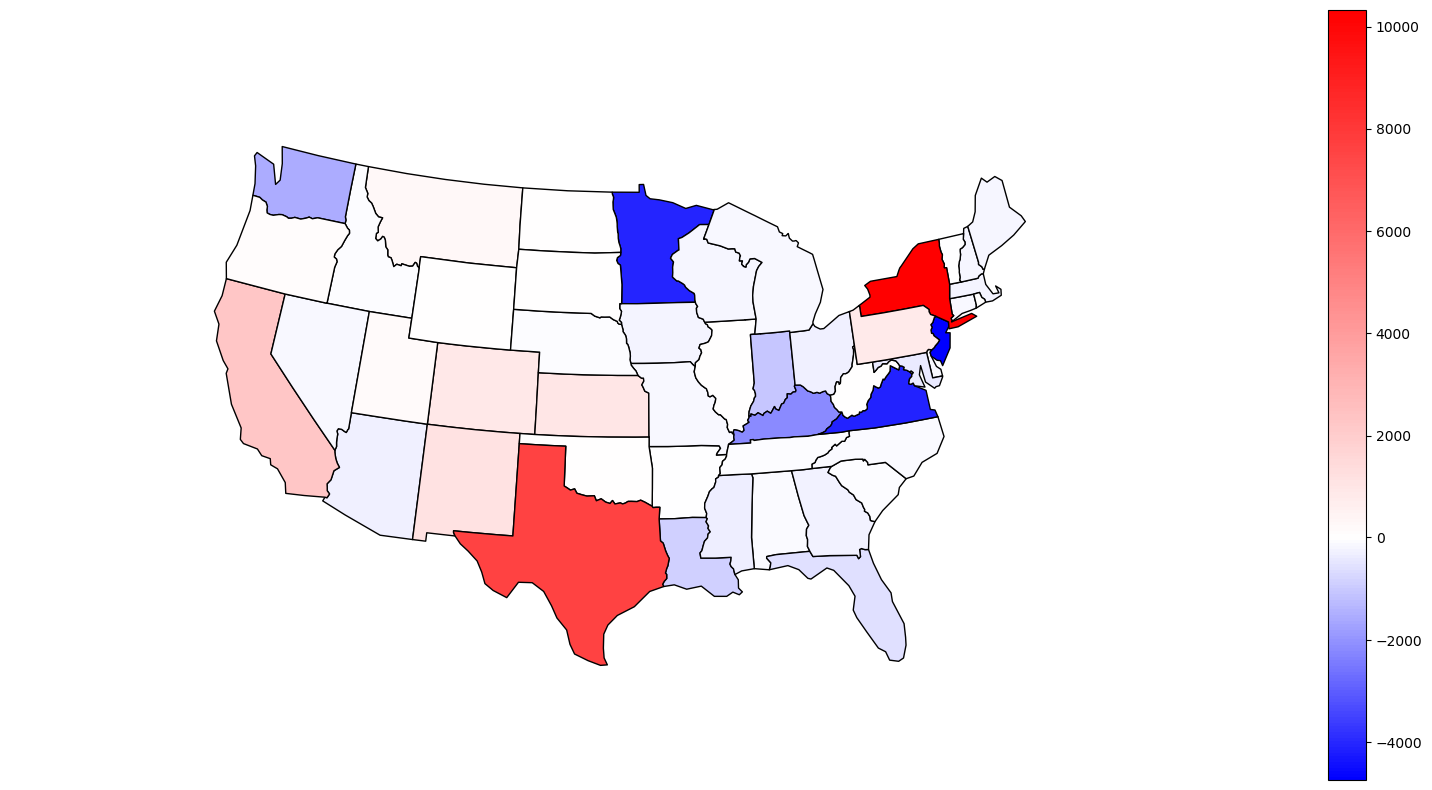

In [305]:
plt.style.use('default')

contiguous_usa['vote_like_count'] = state_likes

vmin, vmax, vcenter = contiguous_usa['vote_like_count'].min(), contiguous_usa['vote_like_count'].max(), 0
div_norm = colors.DivergingNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)

gplt.choropleth(
    contiguous_usa,
    hue='vote_like_count',
    projection=gcrs.AlbersEqualArea(),
    edgecolor='black',
    linewidth=1,
    cmap='bwr',
    norm=div_norm,
    figsize=(20, 10),
    legend=True,
)

In [306]:
contiguous_usa

state adm1_code  population  \
0              Minnesota  USA-3514     5303925   
1                Montana  USA-3515      989415   
2           North Dakota  USA-3516      672591   
3                  Idaho  USA-3518     1567582   
4             Washington  USA-3519     6724540   
5                Arizona  USA-3520     6392017   
6             California  USA-3521    37253956   
7               Colorado  USA-3522     5029196   
8                 Nevada  USA-3523     2700551   
9             New Mexico  USA-3524     2059179   
10                Oregon  USA-3525     3831074   
11                  Utah  USA-3526     2763885   
12               Wyoming  USA-3527      563626   
13              Arkansas  USA-3528     2915918   
14                  Iowa  USA-3529     3046355   
15                Kansas  USA-3530     2853118   
16              Missouri  USA-3531     5988927   
17              Nebraska  USA-3532     1826341   
18              Oklahoma  USA-3533     3751351   
19          South Dakota  USA-3534      814180   
20             Louisiana  USA-3535     4533372   
21                 Texas  USA-3536    25145561   
22           Connecticut  USA-3537     3574097   
23         Massachusetts  USA-3513     6547629   
24         New Hampshire  USA-3538     1316470   
25          Rhode Island  USA-3539     1052567   
26               Vermont  USA-3540      625741   
27               Alabama  USA-3541     4779736   
28               Florida  USA-3542    18801310   
29               Georgia  USA-3543     9687653   
30           Mississippi  USA-3544     2967297   
31        South Carolina  USA-3545     4625364   
32              Illinois  USA-3546    12830632   
33               Indiana  USA-3547     6483802   
34              Kentucky  USA-3548     4339367   
35        North Carolina  USA-3549     9535483   
36                  Ohio  USA-3550    11536504   
37             Tennessee  USA-3551     6346105   
38              Virginia  USA-3552     8001024   
39             Wisconsin  USA-3553     5686986   
40         West Virginia  USA-3554     1852994   
41              Delaware  USA-3555      897934   
42  District of Columbia  USA-3556      601723   
43              Maryland  USA-3557     5773552   
44            New Jersey  USA-3558     8791894   
45              New York  USA-3559    19378102   
46          Pennsylvania  USA-3560    12702379   
47                 Maine  USA-3561     1328361   
48              Michigan  USA-3562     9883640   

                                             geometry  vote_like_count  
0   POLYGON ((-89.59941 48.01027, -89.48888 48.013...            -4052  
1   POLYGON ((-111.19419 44.56116, -111.29155 44.7...              260  
2   POLYGON ((-96.60136 46.35136, -96.53891 46.199...                0  
3   POLYGON ((-111.04973 44.48816, -111.05025 42.0...              -67  
4   POLYGON ((-116.99807 46.33017, -116.90653 46.1...            -1520  
5   POLYGON ((-109.04523 36.99991, -109.04367 31.3...             -262  
6   POLYGON ((-114.35490 34.46467, -114.16597 34.2...             2283  
7   POLYGON ((-102.05017 40.00082, -102.04012 38.4...              907  
8   POLYGON ((-114.03053 36.99410, -114.02363 36.1...             -138  
9   POLYGON ((-103.00161 33.87995, -103.00161 31.9...             1190  
10  POLYGON ((-117.02825 42.00002, -117.02825 41.9...               97  
11  POLYGON ((-109.05318 41.00199, -109.04523 36.9...              165  
12  POLYGON ((-111.06719 44.54160, -111.07141 45.0...               12  
13  POLYGON ((-89.66292 36.02307, -89.67351 35.940...              -27  
14  POLYGON ((-90.15664 42.10374, -90.21007 41.834...             -204  
15  POLYGON ((-94.60481 39.13986, -94.61538 38.068...              984  
16  POLYGON ((-94.61750 36.99991, -94.62280 36.999...             -143  
17  POLYGON ((-95.45254 40.21514, -95.32288 40.001...              -67  
18  POLYGON ((-94.62861 36.54059, -94.43017 35.483...                7  
19  POLYGON ((-96.75427 42.63396, -97.02839 42.717...     

In [299]:
ny_republican_comments = []

for i, post in republicans.iterrows():
    caption = post[CAPTION_COLUMN_NAME].lower()
    like_count = post[LIKE_COUNT_COLUMN_NAME]
    
    if 'new york' in caption or 'newyork' in caption:
        ny_republican_comments.append(caption)

ny_republican_comments_str = ' '.join(ny_republican_comments)

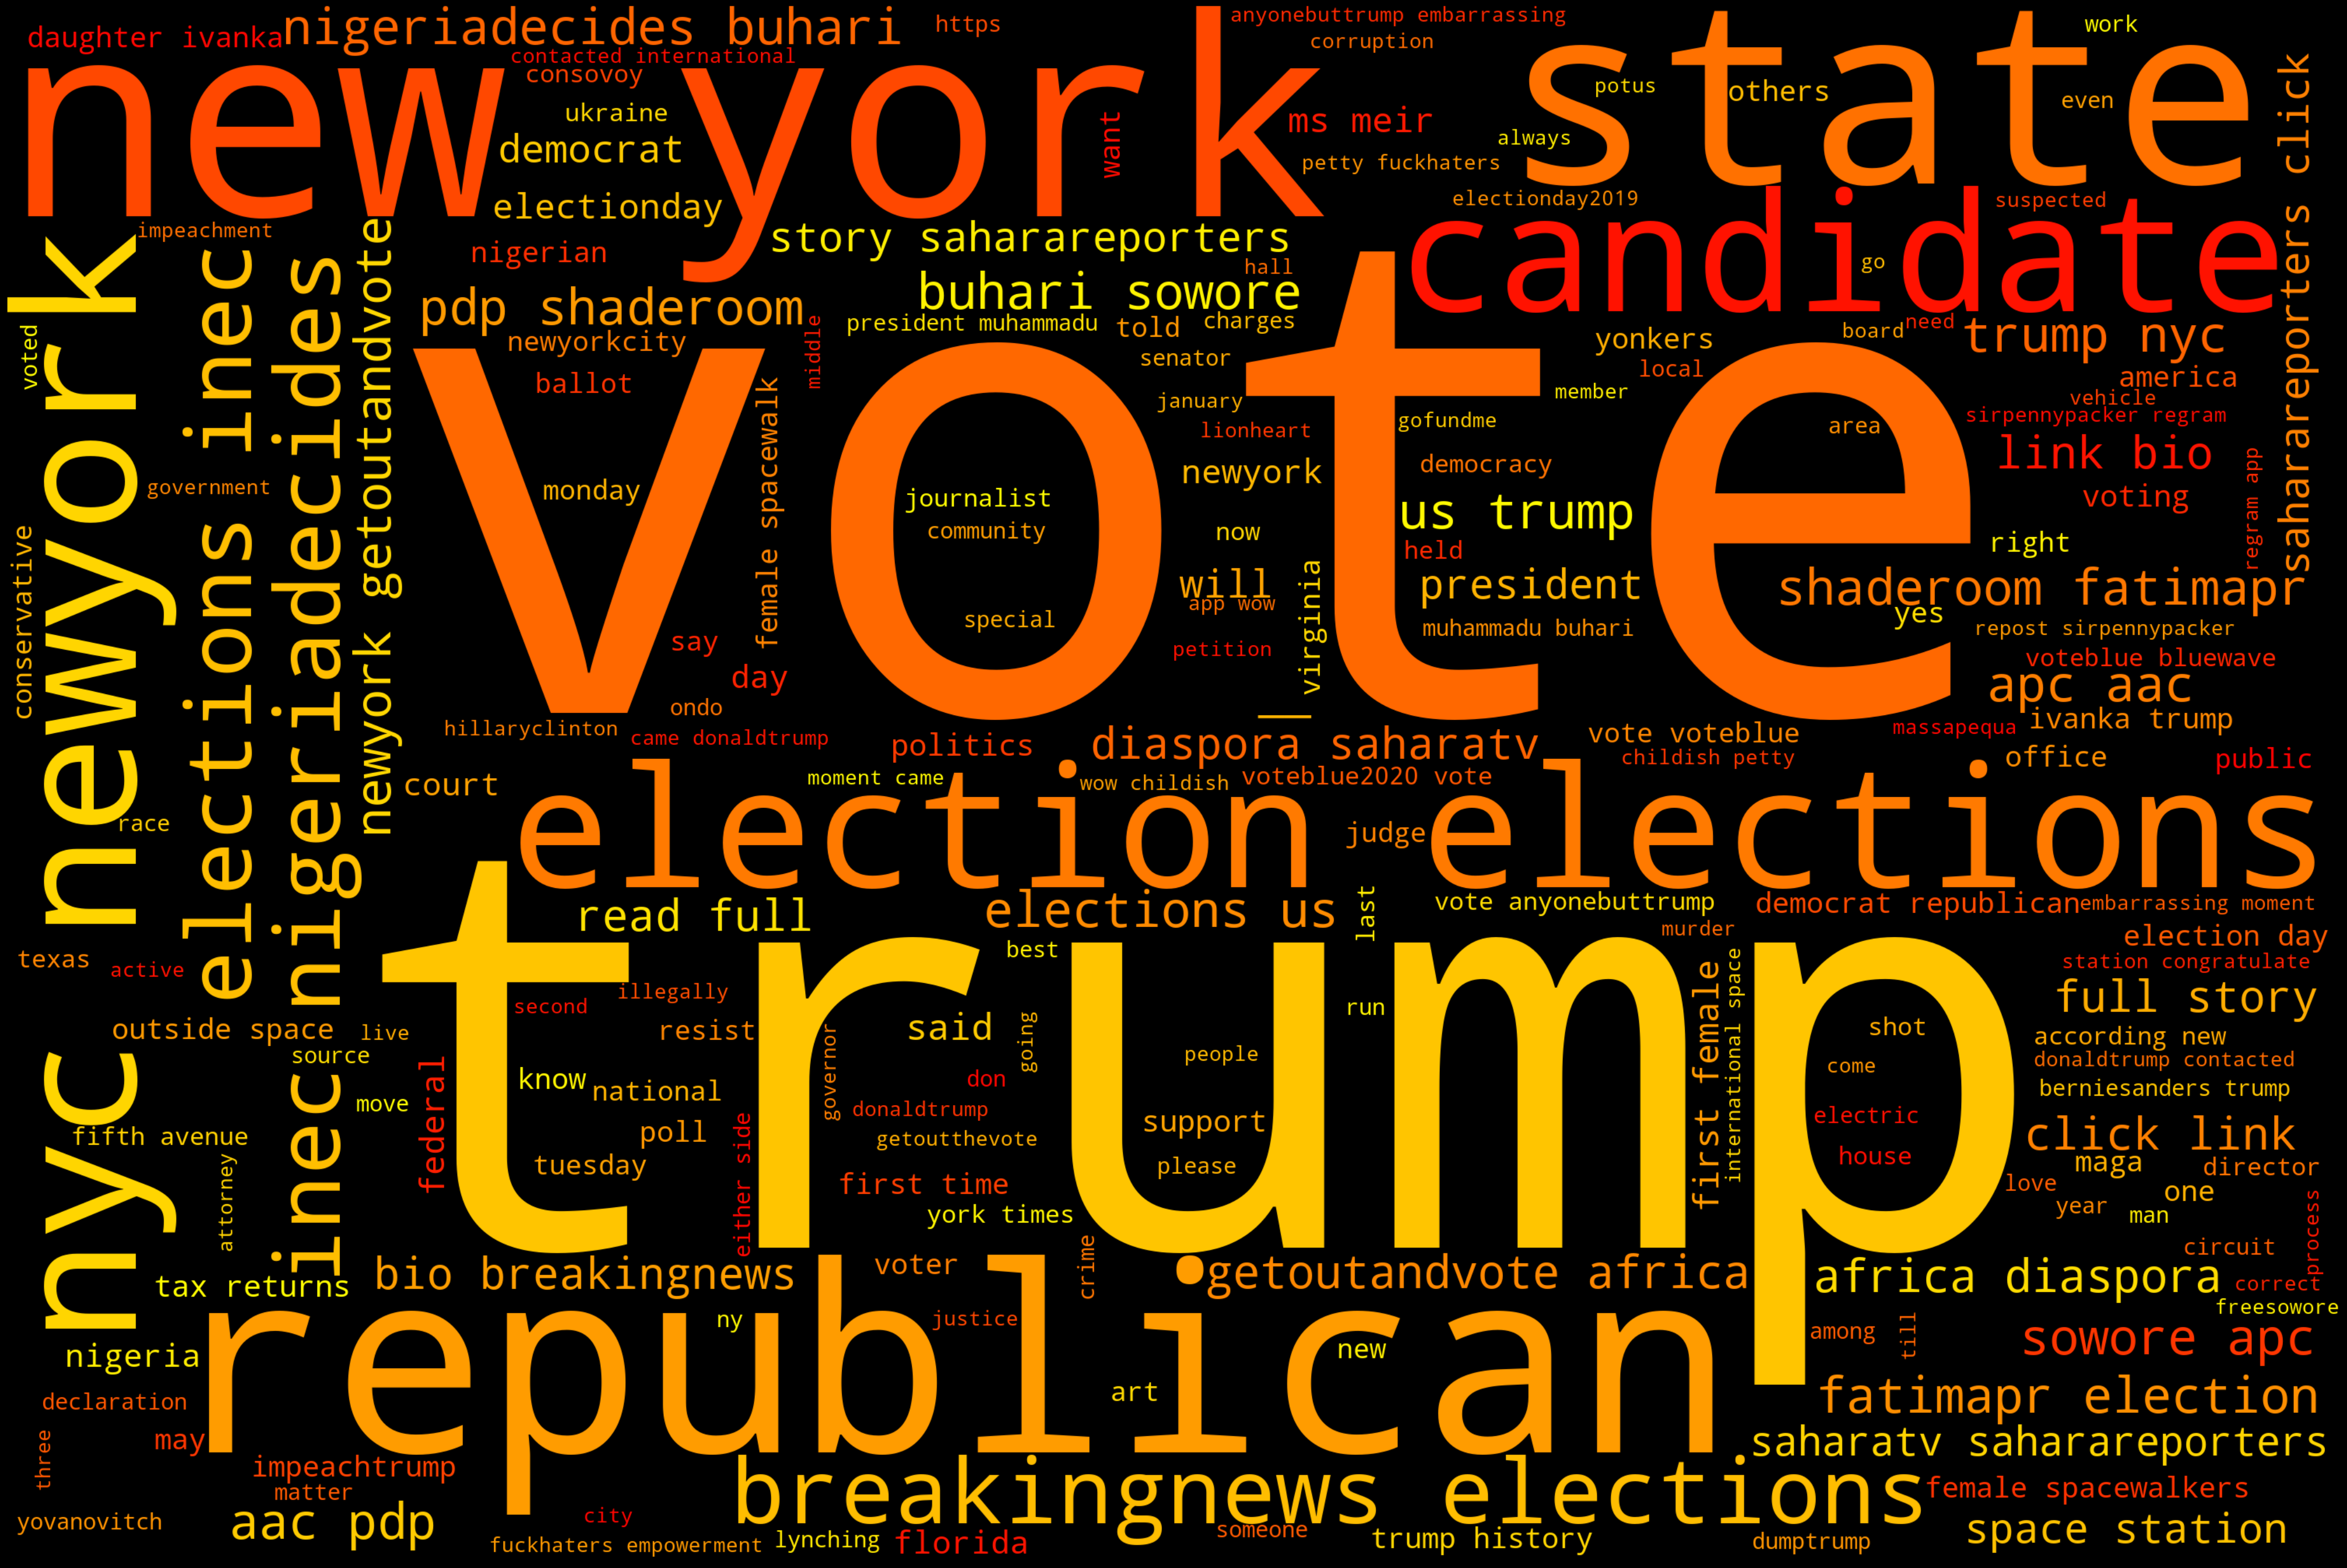

In [300]:
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    colormap='autumn',
    background_color = 'black',
    stopwords = STOPWORDS).generate(ny_republican_comments_str)

fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [307]:
for comment in ny_republican_comments[:5]:
    print(comment)
    print('\n****************\n')

hope yall voted 🗳👱🏻‍♂️
.
.
.
.
#election2019 #newyorkrap #hiphop  #deejay #musicpublishing #musicpublisher #republican #vote

****************

🗳our @sharieinhorn12 is ready for #electionday coverage! are you?! ✅ ~ “staking out my spot for the foreseeable future here in #patchogue. it’s that time again #n12votes. we’ll be here at #suffolk #republican hq all night. tune in for results.” #longisland #newyork #vote

****************

🗽#newyorkers know what we want 🤷🏻‍♀️ found this on the steps of the #mta 14st train station😏
#nyc #ivoted
#lockhimup #trumprussianpuppet
#notmypresident 
#impeachthemotherfucker 
#whistleblower 
#vote
#2020elections
#racism
#impeachtrump 
#stablegenius
#trumptaxes
#notmypresident 
#donaldtrumpsucks
#believesurvivors
#immigration
#powertothepolls
#enoughisenough
#shitholepresident
#metoo
#boycottnra
#resist
#resisttrump
#sociopathinchief
#healthcare
#climatechange
#defenddaca
#goptaxbill

****************

#repost @bitches.of.karma with @get_repost
・・・
#repost

In [302]:
va_democratic_comments = []

for i, post in democrats.iterrows():
    caption = post[CAPTION_COLUMN_NAME].lower()
    like_count = post[LIKE_COUNT_COLUMN_NAME]
    
    if 'virginia' in caption:
        va_democratic_comments.append(caption)

va_democratic_comments_str = ' '.join(va_democratic_comments)

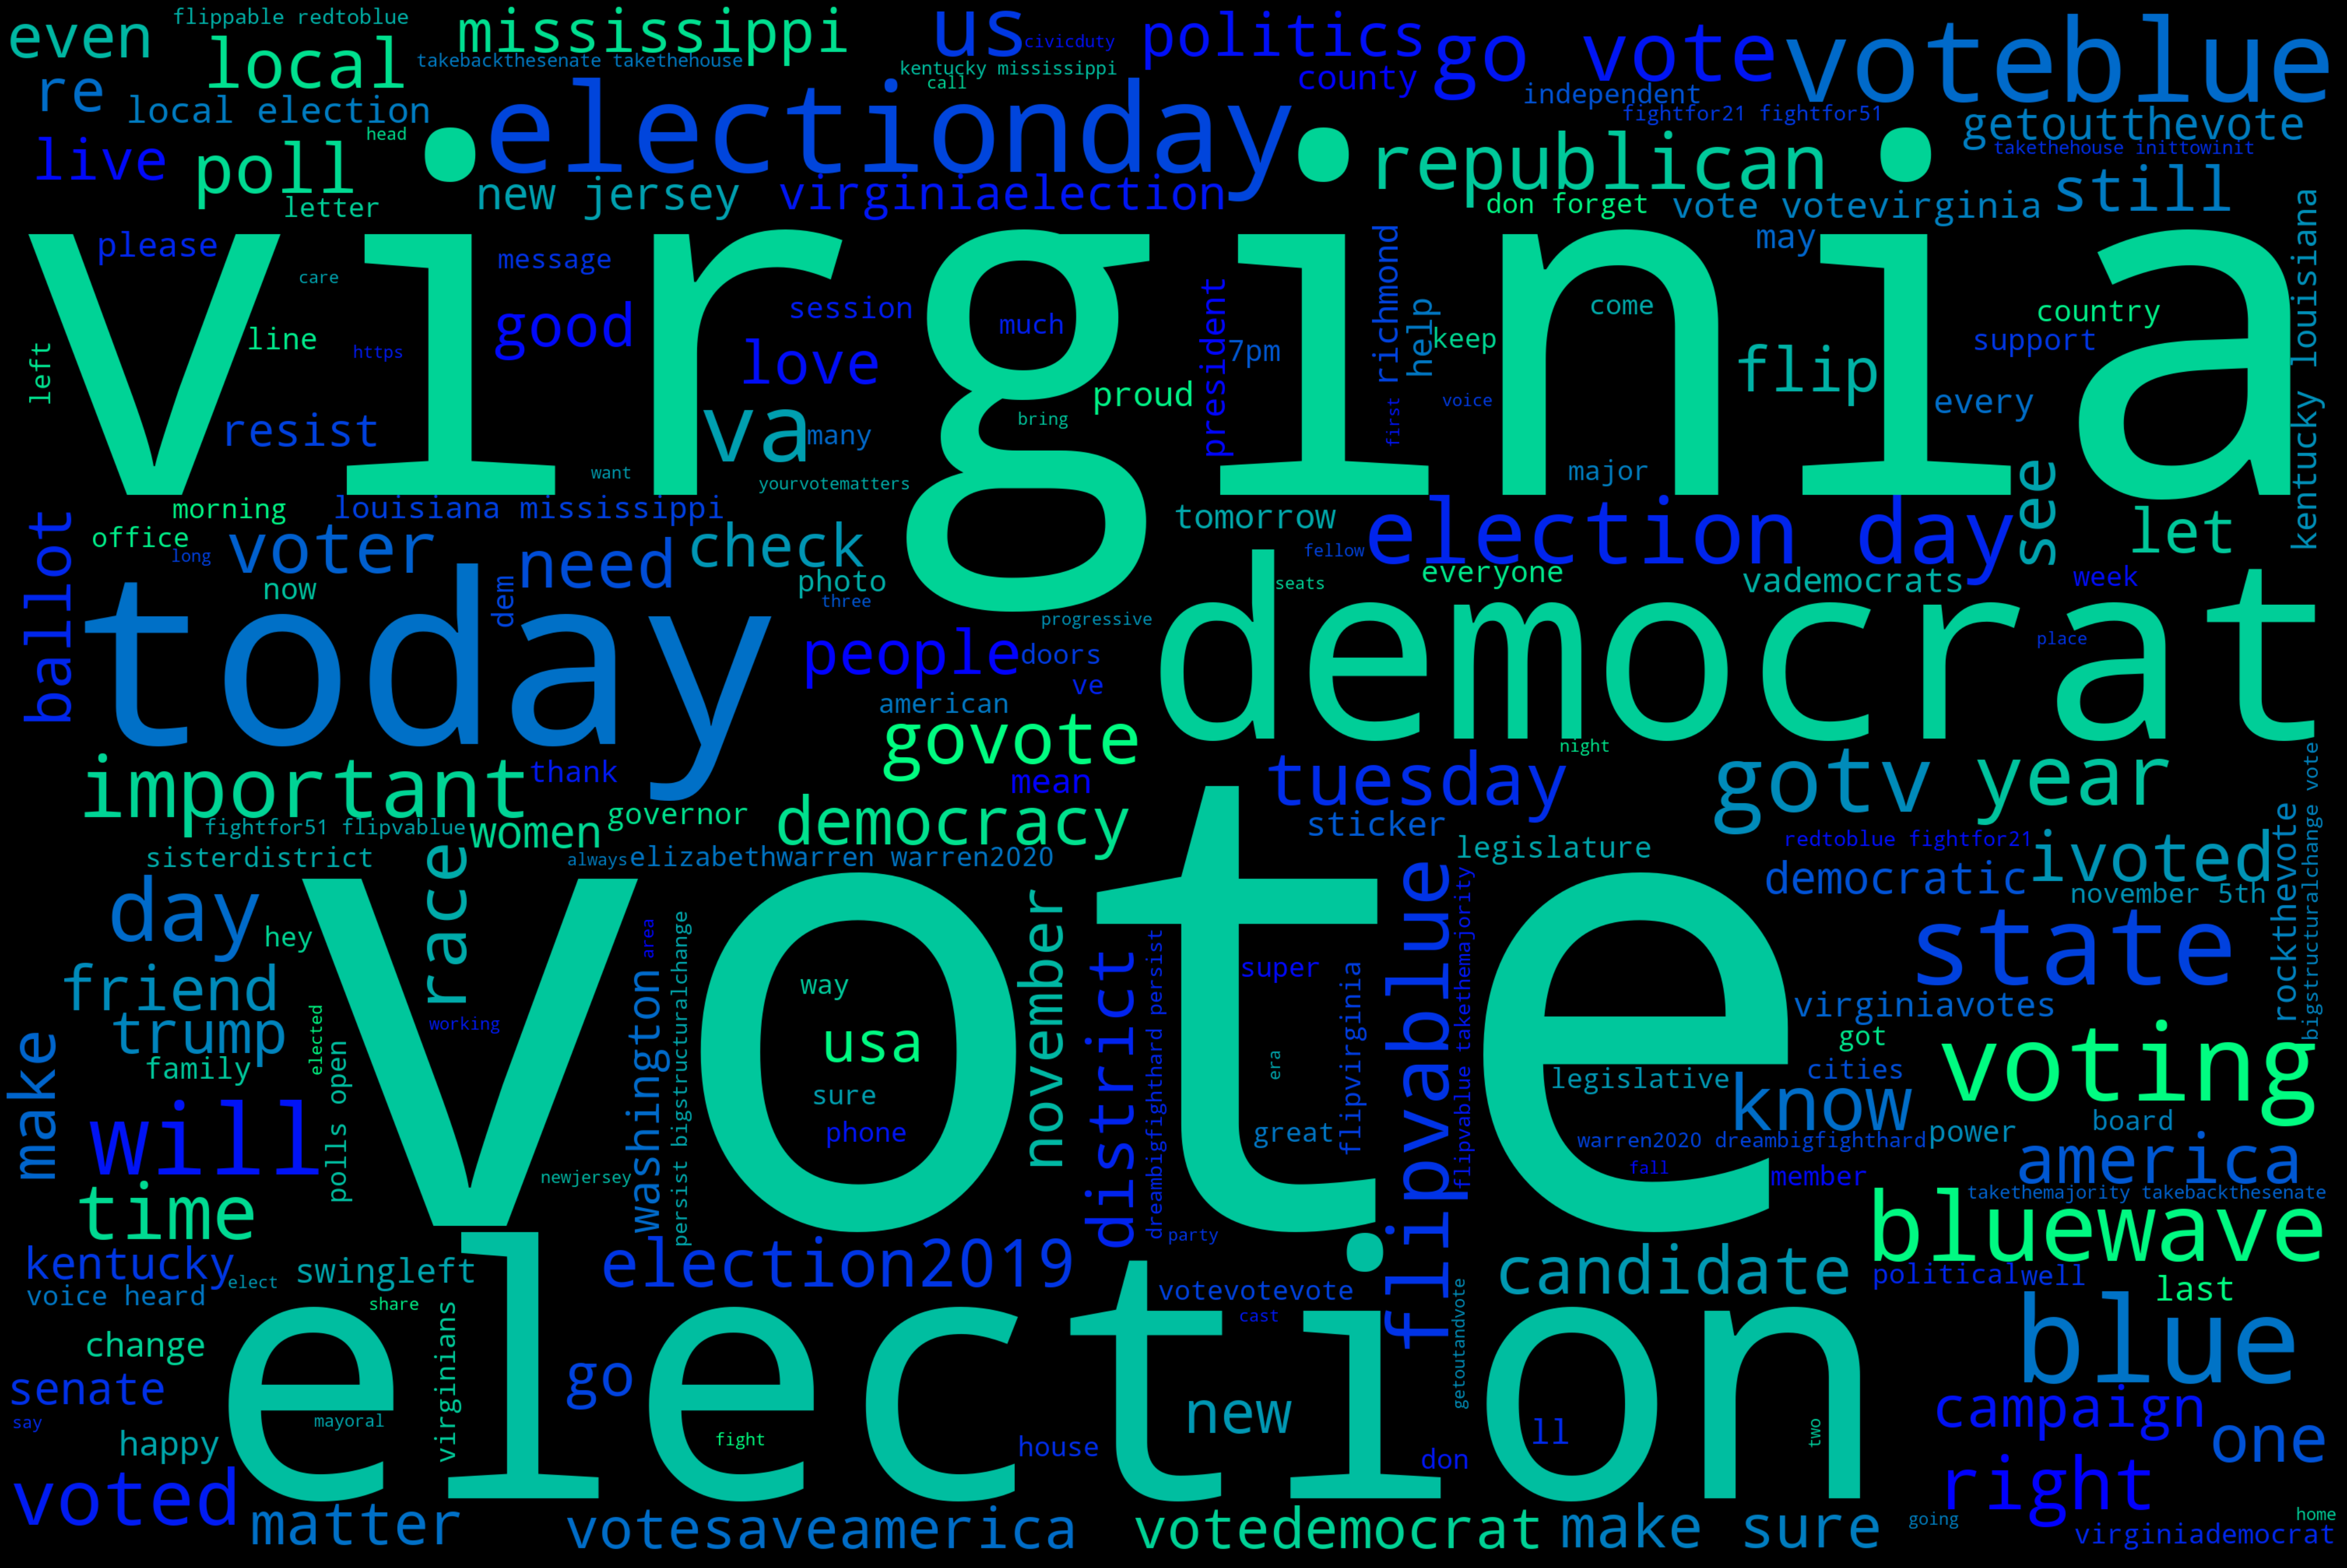

In [303]:
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    colormap='winter',
    background_color = 'black',
    stopwords = STOPWORDS).generate(va_democratic_comments_str)

fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [308]:
for comment in va_democratic_comments[:5]:
    print(comment)
    print('\n****************\n')

election day gotv phone banking for virginia and delaware county #democrats with zucchini. he’s making sure you all vote!
#gotv #votesaveamerica #vote #phillyvotes #votepa #votedemocratic

****************

don't let the bastards grind you down! go vote! you've got two more hours, virginia. 💙 keep richmond blue! 💙 #vote #ivoted #everybodyvote #virginiavoter

****************

proud to vote for joe @_joemorrissey 🤞🏼🤜🏼🤛🏼 #vote #voteforjoemorrissey #election2019 #election #2019 #virginia #richmond #senate #democrats #senateofvirginia #congress

****************

virginia friends! don’t forget to go out to vote today! you still have a few hours left! #virginia #vadems #arlington #arlingtondemocrats #vote #flipvablue

****************

#vote #virginiaelections #polls #gunsense #voteblue #votesaveamerica #gunsensevoter @momsdemand @drealcorn #votelikeamother#fighttowin

****************

